In [1]:
# imports
import numpy as np
import gym
from gym import utils
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP
import time
import plotly.express as px
from IPython import display

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# to use the render function in colab
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

## Utility Function

In [2]:
# function to print human-readable policy
def print_policy(policy, action_names):
    str_policy = policy.astype('str')
    for action_num, action_name in action_names.items():
        np.place(str_policy, policy == action_num, action_name)

    print(str_policy[0:4])
    print(str_policy[4:8])
    print(str_policy[8:12])
    print(str_policy[12:16])
    
    return str_policy

action_names = {LEFT: 'LEFT', RIGHT: 'RIGHT', DOWN: 'DOWN', UP: 'UP'}

## Environment Setup

In [3]:
# registering the 4x4 deterministic Frozen Lake environment with the Gym library
register(
    id='Deterministic-4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False})

In [4]:
# creating the environment and setting 0.9 as the discount rate gamma
env = gym.make('Deterministic-4x4-FrozenLake-v0')
gamma = 0.9

## Policy Iteration

Starting with a single random policy, Policy Iteration then evaluates that policy to determine its value function. The action that maximises the value function for each state is then chosen to improve the policy. Until the policy converges on an ideal policy, this process continues. In a limited number of iterations, policy iteration ensures convergence to the best course of action.

In [5]:
# function to evaluate the value function from a given policy
def policy_evaluation(env, gamma, policy, value_func_old, max_iterations=int(1e3), theta=1e-3):
    
    value_func_new = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))

    for iteration in range(max_iterations):
        
        delta=0
        
        for s in range(env.nS):
            value_func_temp = 0
            a = policy[s]
            
            # Using env.P[s][a] implement the V(s) updation given in Figure 4.1
            # Note: Since this is a deterministic policy, the summation over
            # action space is not required.
            for next_state_from_tpm in env.P[s][a]:
                prob_action = next_state_from_tpm[0]
                cur_reward=next_state_from_tpm[2]
                future_reward=gamma*value_func_old[next_state_from_tpm[1]]
                value_func_temp+=prob_action*(cur_reward+future_reward)
            
            diff = abs(value_func_old[s]-value_func_temp)
            delta = max(delta,diff)
            
            value_func_new[s] = value_func_temp
        
        # Stopping criteria: STOP when the sup norm of (V_k-V_{k-1}) is less than some theta
        if delta <= theta: break
        
        value_func_old = value_func_new
        value_func_collect[:,iteration] = value_func_old

    return delta, value_func_new, iteration

In [6]:
# function to improve the policy given the value function
def policy_improvement(env, gamma, value_func, policy):
    """
      Given a policy and value function, improve the policy.
      Returns true if policy is unchanged. Also returns the new policy.
      See section 4.2 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    value_func_new = np.zeros(env.nS)
    policy_stable=True
    for s in range(env.nS):
        old_action=policy[s]
        max_value_func=-1
        max_action=-1
        for a in range(env.nA):
            value_func_temp=0
            # Copy and paste the "sum" which you've implemented in the 
            # policy_evaluation function here.
            for next_state_from_tpm in env.P[s][a]:
                prob_action = next_state_from_tpm[0]
                cur_reward = next_state_from_tpm[2]
                future_reward = gamma * value_func[next_state_from_tpm[1]]
                value_func_temp+=prob_action * (cur_reward + future_reward)
            
            if value_func_temp>max_value_func:
                max_value_func=value_func_temp
                max_action=a
        if max_action!=old_action: policy_stable=False
        policy[s]=max_action
        value_func_new[s]=max_value_func
    return policy_stable, policy, value_func_new

In [7]:
# function to implement iteration
def policy_iteration(env, gamma, nS, nA, max_iterations=int(1e3), theta=1e-3):
    """
       Runs policy iteration.
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
    """
    env.nS = nS
    env.nA = nA
    policy = np.random.randint(4, size = env.nS)
    value_func_old = np.random.rand(env.nS)
    value_func = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS, max_iterations))
    delta_collect = np.zeros(max_iterations)
    policy_stable = False
    iters = 0
    eval_iters = 0
    while not policy_stable:
        delta, value_func, iter = policy_evaluation(env, gamma, policy, value_func_old)
        delta_collect[iters] = delta
        value_func_collect[:, iters] = value_func
        eval_iters += iter
        policy_stable, policy, value_func_old = policy_improvement(env, gamma, value_func, policy)
        iters += 1

    return policy, value_func, iters, eval_iters

In [8]:
# displaying performance of policy iteration in an episode
print("-"*25 + "\nBeginning Policy Iteration\n" + "-"*25)
start_time = time.time()
policy, value_func, policy_iters, val_iters = policy_iteration(env, gamma, 16, 4)

print("\nTotal time taken: " + str((time.time() - start_time)))
print("Total Policy Improvement Steps: " + str(policy_iters))
print("Total Policy Evaluation Steps: " + str(val_iters))

print("\nValue function:\n", value_func)

print("\nPolicy:")
policy_str = print_policy(policy, action_names)

-------------------------
Beginning Policy Iteration
-------------------------

Total time taken: 0.012122154235839844
Total Policy Improvement Steps: 5
Total Policy Evaluation Steps: 48

Value function:
 [5.91324620e-01 6.56934620e-01 7.29834620e-01 6.56934620e-01
 6.56934620e-01 2.20173279e-03 8.10834620e-01 1.31170468e-03
 7.29834620e-01 8.10834620e-01 9.00834620e-01 2.44751255e-03
 1.08965375e-03 9.00834620e-01 1.00083462e+00 8.34620454e-04]

Policy:
['DOWN' 'RIGHT' 'DOWN' 'LEFT']
['DOWN' 'LEFT' 'DOWN' 'LEFT']
['RIGHT' 'DOWN' 'DOWN' 'LEFT']
['LEFT' 'RIGHT' 'RIGHT' 'LEFT']


## Value Iteration

Value Iteration updates a random initial value function iteratively until it finds the best value function. The action that maximises the sum of the immediate reward and the discounted value of the following state is chosen for each iteration in order to update the value of each state. Until the value function converges to the ideal value function, the process is repeated. Moreover, value iteration ensures that the ideal value function will be reached in a limited amount of repetitions.

In [9]:
# function to implement iteration
def value_iteration(env, gamma, max_iterations=int(1e3), theta=1e-3):
    """
    Runs value iteration for a given gamma and environment. Return 
    the value function and the number of iterations it took to converge.
    """
    value_func_old = np.random.rand(env.nS)
    value_func_new = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))
    delta_collect = np.zeros(max_iterations)

    for iteration in range(max_iterations):
        delta=0
        for s in range(env.nS):
            max_value_func = -1
            
            # Refer Figure 4.5 for the algorithm
            # Parse through env.nA for finding the maximum
            # Using env.P[s][a] implement the V(s) updation
            for a in range(env.nA):
                value_func_temp = 0
                for next_state_from_tpm in env.P[s][a]: 
                    prob_action = next_state_from_tpm[0]
                    cur_reward=next_state_from_tpm[2]
                    if next_state_from_tpm[3]:
                        future_reward=0
                    else: future_reward = gamma * value_func_old[next_state_from_tpm[1]]
                    value_func_temp += prob_action * (cur_reward + future_reward)
                if value_func_temp > max_value_func:
                    max_value_func = value_func_temp
                    
            diff = abs(value_func_old[s] - max_value_func)
            delta = max(delta, diff)
            value_func_new[s] = max_value_func

        delta_collect[iteration] = delta
        value_func_old = value_func_new
        value_func_collect[:, iteration] = value_func_old
        # Stopping criteria: STOP when the sup norm of (V_k-V_{k-1}) is less than some theta
        if delta <= theta: break
    return value_func_new, iteration

In [10]:
# function to convert value function to policy
def value_function_to_policy(env, gamma, value_function):
    """
    Mapping actions for each state using the value_function to get a policy
    """
    policy = np.zeros(env.nS, dtype='int')
    for s in range(env.nS):
        max_value_func = -1
        max_action = -1
        for a in range(env.nA):
            value_func_temp = 0
            for next_state_from_tpm in env.P[s][a]:
                prob_action = next_state_from_tpm[0]
                cur_reward = next_state_from_tpm[2]
                future_reward = gamma * value_function[next_state_from_tpm[1]]
                value_func_temp += prob_action * (cur_reward + future_reward)
            if value_func_temp > max_value_func:
                max_value_func = value_func_temp
                max_action = a
        policy[s] = max_action

    return policy

In [11]:
# displaying performance of value iteration in an episode
print("-"*25 + "\nBeginning Value Iteration\n" + "-"*25)
start_time = time.time()
value_function, value_iters=value_iteration(env, gamma)

print("\nTotal time taken: " + str((time.time() - start_time)))
print("Total Value Iteration Steps: " + str(value_iters))
print("\nValue function:\n " + str(value_function))

print("\nPolicy:")
policy = value_function_to_policy(env, gamma, value_function)
policy_str = print_policy(policy, action_names)

-------------------------
Beginning Value Iteration
-------------------------

Total time taken: 0.0021886825561523438
Total Value Iteration Steps: 6

Value function:
 [0.59049 0.6561  0.729   0.6561  0.6561  0.      0.81    0.      0.729
 0.81    0.9     0.      0.      0.9     1.      0.     ]

Policy:
['DOWN' 'RIGHT' 'DOWN' 'LEFT']
['DOWN' 'LEFT' 'DOWN' 'LEFT']
['RIGHT' 'DOWN' 'DOWN' 'LEFT']
['LEFT' 'RIGHT' 'RIGHT' 'LEFT']


## 1000 Episodes

In [12]:
# running policy iteration for 1000 episodes
num_episodes = 1000
wins = 0
returns = []
policy, value_func, policy_iters, val_iters = policy_iteration(env, gamma, 16, 4)

for i_episode in range(num_episodes):
    obs = env.reset()
    done = False
    episode_return = 0
    while not done:
        action = policy[obs]
        obs, reward, done, info = env.step(action)
        episode_return += reward
    returns.append(episode_return)
    if episode_return > 0:
        wins += 1

avg_return = sum(returns) / num_episodes
print("Number of wins: ", wins)
print("Average return: ", avg_return)

Number of wins:  1000
Average return:  1.0


In [13]:
# running value iteration for 1000 episodes
wins = 0
returns = []
value_function, value_iters=value_iteration(env, gamma)
policy = value_function_to_policy(env, gamma, value_function)

for i_episode in range(num_episodes):
    obs = env.reset()
    done = False
    episode_return = 0
    while not done:
        action = policy[obs]
        obs, reward, done, info = env.step(action)
        episode_return += reward
    returns.append(episode_return)
    if episode_return > 0:
        wins += 1

avg_return = sum(returns) / num_episodes
print("Number of wins: ", wins)
print("Average return: ", avg_return)

Number of wins:  1000
Average return:  1.0


## Episode Render

In [14]:
# function to render one episode with the obtained optimal policy
def render_single(env, policy, max_steps=100):
  """
    This function does not need to be modified
    Renders policy once on environment. Watch your agent play!

    Parameters
    ----------
    env: gym.core.Environment
      Environment to play on. Must have nS, nA, and P as
      attributes.
    Policy: np.array of shape [env.nS]
      The action to take at a given state
  """

  episode_reward = 0
  obs = env.reset()
  for i in range(max_steps):
    action = policy[obs]
    obs, reward, done, _ = env.step(action)
    episode_reward += reward
    img = env.render(mode='rgb_array')
    display.clear_output(wait=True)
    fig = px.imshow(img)
    fig.update_layout(autosize=False, width=500, height=500, margin=dict(l=10, r=10, t=10, b=10))
    fig.show()
    if done:
        break
  if not done:
    print("\nThe agent didn't reach a terminal state in {} steps.\n".format(max_steps))
  else:
  	print("\nEpisode reward: %f\n" % episode_reward)


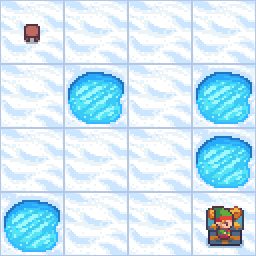


Episode reward: 1.000000



In [15]:
render_single(env, policy, 100)

The agent was able to reach the goal state without falling into a hole using the optimal policy.

## Overall Inference

Both algorithms found the optimal policy and won every episode.

The main difference between policy iteration and value iteration is that policy iteration requires policy evaluation at each step, while value iteration performs policy evaluation implicitly by iteratively updating the value function. This makes value iteration more computationally efficient than policy iteration. 

However, since the Frozen Lake environment is a relatively simple environment with a small state space, it is easier for both policy iteration and value iteration to converge to optimal solutions quickly.